In [3]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import pickle
from torch import nn
import torch.nn.functional as F
from torch.autograd import Variable
plt.rcParams.update({'font.size': 15})
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
class emptyObject(object): pass

In [4]:
with open('allDend/mixedori/NMDA_ApN0.5_13_passive_r0_o2_i2_g_b0.pkl', 'rb') as fo:
    data = pickle.load(fo, encoding='bytes')
data = data[0]

In [5]:
def spike_time2spike_train(data):
    nReps = len(data.vdata)
    time_dur = len(data.vdata[0])
    Nsyn_e = 629
    Nsyn_i = 120
    spike_train = np.zeros((nReps, Nsyn_e+Nsyn_i, time_dur))
    for i in range(nReps):
        ind_etimes = (data.stim[:,0] == i + 1)
        etimes = np.array(data.stim[ind_etimes,:])
        etimes = etimes[:,(1,2)]
        for j in range(len(etimes)):
            spike_train[i, int(etimes[j, 0]), int(etimes[j, 1] * 5)] = 1

        ind_itimes = (data.stim[:,0] == -1 * i - 1)
        itimes = np.array(data.stim[ind_itimes,:])
        itimes = itimes[:,(1,2)]
        for j in range(len(itimes)):
            spike_train[i, int(itimes[j, 0]) + Nsyn_e, int(itimes[j, 1] * 5)] = 1
    return spike_train

In [7]:
X_train_std = spike_time2spike_train(data)
Y_train = np.array(data.vdata)

In [8]:
Y_train_std = np.empty_like(Y_train)
Y_train_std = (Y_train - np.mean(Y_train)) / np.std(Y_train)

Y_train_std = torch.tensor(Y_train_std).to(device)
Y_train_std = Y_train_std.to(torch.float32)

X_train_std = torch.tensor(X_train_std).to(device)
X_train_std = X_train_std.to(torch.float32)

In [15]:
Nsyn = 749
time_dur = Y_train.shape[1]
def kernel(time_dur, tau_rise, tau_decay):
    T = torch.arange(time_dur).to(device)
    y = (1 - torch.exp(-T / tau_rise)) * torch.exp(-T / tau_decay)
    return torch.flip(y, dims=[0])

def Kernel(time_dur, in_channels, Tau_rise, Tau_decay):
    y = torch.empty(1, in_channels, time_dur)
    for i in range(in_channels):
        y[0, i] = kernel(time_dur, Tau_rise[i], Tau_decay[i])
    return y.to(device)

In [14]:
a = torch.rand((1, 3, 1))
b = torch.rand((1, 2, 1))
c = torch.cat((a, b), 1)
c.size()

torch.Size([1, 5, 1])

In [65]:
class model(nn.Module):
    def __init__(self, time_dur, in_channels):
        super(model, self).__init__()
        self.time_dur = time_dur
        self.in_channels = in_channels
        weight1 = torch.ones((1, 630, 1), requires_grad=True) * 0.1
        weight2 = torch.ones((1, 119, 1), requires_grad=True) * -0.1
        weight = torch.cat((weight1, weight2), 1)
        self.weight = nn.Parameter(weight)
        Tau_rise = torch.ones(749, requires_grad=True) * 15 
        self.Tau_rise = nn.Parameter(Tau_rise)
        Tau_decay = torch.ones(749, requires_grad=True) * 40 
        self.Tau_decay = nn.Parameter(Tau_decay)
        # c = torch.ones(1, requires_grad=True) * 45
        # self.c = nn.Parameter(c)
        # theta = torch.ones(1, requires_grad=True) * -1.2
        # self.theta = nn.Parameter(theta)
        bias = torch.ones(1, requires_grad=True) * -3
        self.bias = nn.Parameter(bias)

    def forward(self, x):
        filter = Kernel(time_dur=self.time_dur, in_channels=self.in_channels, Tau_rise=self.Tau_rise, Tau_decay=self.Tau_decay) * self.weight
        x = F.conv1d(x, filter, padding=self.time_dur, bias=self.bias)
        #x = nn.Sigmoid()(x-self.theta) * self.c + self.bias
        x = torch.squeeze(x)[:, :self.time_dur]
        return x

In [66]:
N_sample = X_train_std.shape[0]
in_channels = X_train_std.shape[1]
time_dur = X_train_std.shape[2]
net = model(time_dur, in_channels)
net.to(device)
error = nn.MSELoss()
learning_rate = 0.01
optimizer = torch.optim.SGD(net.parameters(), lr=learning_rate)

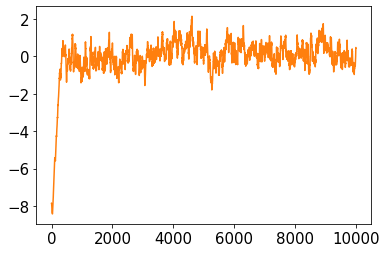

In [71]:
idx = 0
train = Variable(X_train_std)
output = net(train)
plt.plot(output[idx].cpu().detach().numpy())
plt.plot(Y_train_std[idx].cpu().detach().numpy())

In [68]:
# ANN model training
num_epochs = 100
loss_train_list = []
iteration_list = []
loss_test_list = []
train = Variable(X_train_std)
tr_labels = Variable(Y_train_std)

for epoch in range(num_epochs):
    outputs = net(train) # Forward propagation
    loss_train = error(outputs, tr_labels) # Calculate loss
    loss_train.backward() # Calculating gradients
    #loss_train.backward(retain_graph=True) 
    optimizer.step() # Update parameters
    optimizer.zero_grad() # Clear gradients
        
    if epoch % 10 == 0:
        print('Iteration: {}  Train_Loss: {}'.format(epoch, loss_train.data.item()))
print('Final: Train_Loss: {} '.format(loss_train.data.item()))

Iteration: 0  Train_Loss: 0.9594079852104187
Iteration: 10  Train_Loss: nan
Iteration: 20  Train_Loss: nan


KeyboardInterrupt: 

In [70]:
output[0]

tensor([nan, nan, nan,  ..., nan, nan, nan], device='cuda:0',
       grad_fn=<SelectBackward>)

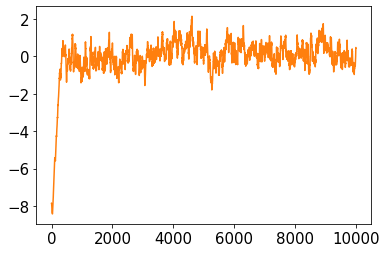

In [69]:
idx = 0
output = net(train)
plt.plot(output[idx].cpu().detach().numpy())
plt.plot(Y_train_std[idx].cpu().detach().numpy())